In [96]:
!python -V

Python 3.8.11


In [97]:
import pandas as pd

In [98]:
import pickle

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

### Reading the data for january 2021

In [101]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df.shape

(1154112, 7)

In [102]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037


### Computing the duration variable

In [103]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)


In [104]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037,15.216667


In [105]:
df.shape

(1154112, 8)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        float64       
 6   Affiliated_base_number  1153227 non-null  object        
 7   duration                1154112 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 70.4+ MB


### Mean duration of travels

In [107]:
df.duration.mean()

19.1672240937939

### Checking the distribution of he duration variable

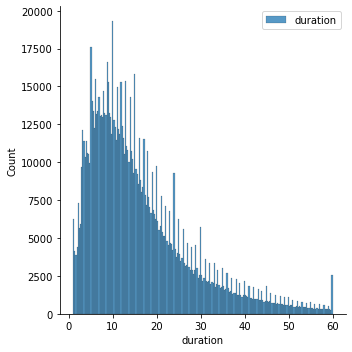

In [129]:
sns.displot(df['duration'], label='duration')

plt.legend()

### Removing Outliers

In [109]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

### Checking the distribution of he duration variable after removing outliers

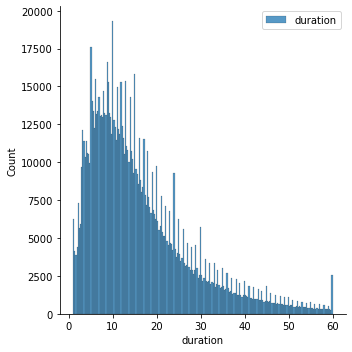

In [128]:
sns.displot(df['duration'], label='duration')

plt.legend()

### Changing 'PUlocationID', 'DOlocationID' to object to be able to categorical encoding them

In [111]:
categorical = ['PUlocationID', 'DOlocationID']
#numerical = ['trip_distance'] We are not going to use numerical features in our model

df[categorical] = df[categorical].astype(str)

In [112]:
df[categorical].dtypes

PUlocationID    object
DOlocationID    object
dtype: object

### Replacing 'nan' for -1 for the pickup and dropoff location IDs

In [113]:
df['PUlocationID'] = df['PUlocationID'].replace('nan', -1)
df['DOlocationID'] = df['DOlocationID'].replace('nan', -1)

### fractions of missing values for the pickup location ID

In [115]:
fr = df[df['PUlocationID'] == -1].shape[0] / df.shape[0]
fr

0.8352732770722617

### Turn the dataframe into a list of dictionaries for the 2 features we are going to use in our model

In [116]:
train_dicts = df[categorical].to_dict(orient='records')

### Fitting a dictionary vectorizer and getting a feature matrix from it

In [118]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [119]:
# dimensionality of this matrix
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

### Training a linear model

In [120]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107212867

### Distribution of predicted vs actual

/home/andresleonardobecerral/.conda/envs/fastaiX/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andresleonardobecerral/.conda/envs/fastaiX/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


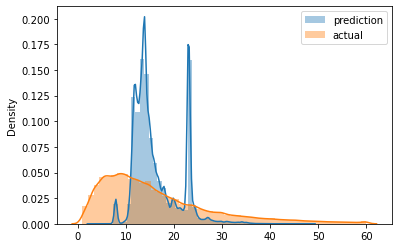

In [134]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend();

### Creating a function to automate the process of reading, and feature engineering the data

In [ ]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

### Reading Train and validation datasets

In [135]:
df_train = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [136]:
len(df_train), len(df_val)

(1109826, 990113)

### Creating validation dictionaries and transforming the validation dataset

In [137]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

### Extracting predicting array for the validation set

In [138]:
target = 'duration'
y_val = df_val[target].values

### Fitting and scoring the model for the validation dataset

In [139]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.364434177060215